This notebook is to demonstrate several techniques of linear regression from OLS to gradient descent. It is to be used alongside medium blog post related to this topic.

<br>

__Link to medium article__: 

In [1]:
SEED = 121
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

random.seed(SEED)
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
%matplotlib inline

np.set_printoptions(suppress=True)

In [2]:
def print_regress_metric(actual, prediction,
                         output_return_bool: bool=False):
    output = dict()
    _r2 = r2_score(actual, prediction)
    _mae = mean_absolute_error(actual, prediction)
    _mse = mean_squared_error(actual, prediction)
    _rmse = math.sqrt(_mse)
    print(f'r2 score = {_r2}\nmae = {_mae}')
    print(f'mse = {_mse}\nrmse = {_rmse}')
    if output_return_bool:
        output['r2'] = _r2
        output['mae'] = _mae
        output['mse'] = _mse
        output['rmse'] = _rmse
        
    return output



## Closed Form Equation

### Quick example using 1 input feature

Generate sample data for linear regression (one input)

In [3]:
X, y, coef = make_regression(n_samples=10000, n_features=1, noise=12.3, 
                             bias=32, random_state=SEED, coef=True)

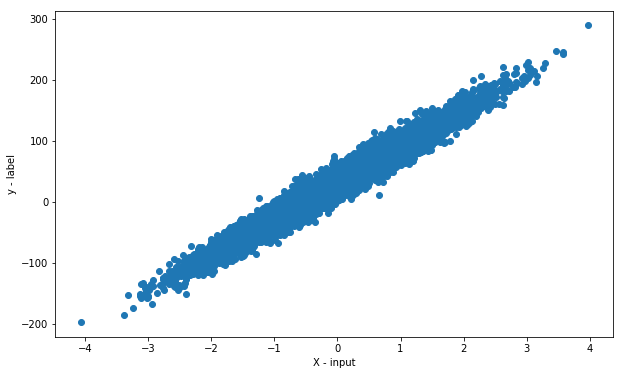

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.xlabel('X - input')
plt.ylabel('y - label')
plt.show()

Add constant column to compute the $B_0$ (intercept)

In [5]:
X_ = sm.add_constant(X)
model = sm.OLS(y, X_).fit()
y_pred = model.predict(X_)

We can get the detail of model (weight and constant) using command below.

In [6]:
model.params

array([31.93475598, 59.47275673])

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 2.262e+05
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:14:42   Log-Likelihood:                -39421.
No. Observations:               10000   AIC:                         7.885e+04
Df Residuals:                    9998   BIC:                         7.886e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.9348      0.125    256.093      0.000      31.690      32.179
x1            59.4728      0.125    475.573      0.000      59.228      59.718
==============================================================================
Omnibus:                        4.469   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                4.766
Skew:                           0.006   Prob(JB):                       0.0923
Kurtosis:                       3.106   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
_ = print_regress_metric(y, y_pred)

r2 score = 0.9576657278190526
mae = 9.895529550837542
mse = 155.4631293828212
rmse = 12.468485448634938


Alternatively, we can find the equation by means of analytical.

__Remark__: we know the formula of single linear regression from the below formula.

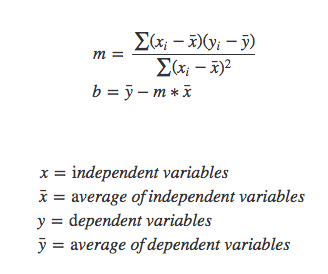


In [9]:
x_mean = np.mean(X)
y_mean = np.mean(y)
n = len(X)

numerator = 0
denominator = 0
for i in range(n):
    numerator += (X[i] - x_mean) * (y[i] - y_mean)
    denominator += (X[i] - x_mean) ** 2
    
b1 = numerator / denominator
b0 = y_mean - (b1 * x_mean)
print(f'constant: {b0}, weight: {b1}')

constant: [31.93475598], weight: [59.47275673]


In [10]:
# or we can use the matrix formulation
np.dot(np.linalg.inv(np.dot(X_.T, X_)), np.dot(X_.T, y))

array([31.93475598, 59.47275673])

Let's visualize the best-fitting line from the model

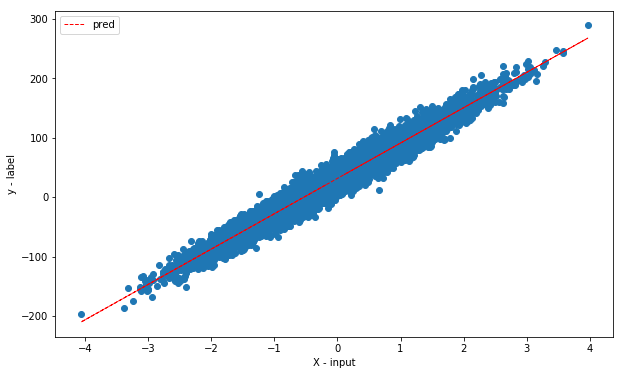

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.xlabel('X - input')
plt.ylabel('y - label')
plt.plot(X, y_pred, '--', color='red', linewidth=1, label='pred')
plt.legend()
plt.show()

Recap all 3 methods:

In [12]:
# matrix formulation
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

X_ = sm.add_constant(X)  # add constant for intercept computation
print('Method 1: matrix formulation')
print(np.dot(np.linalg.inv(np.dot(X_.T, X_)), np.dot(X_.T, y)))

# statsmodels lib
model = sm.OLS(y, X_).fit()
print('Method 2: statsmodels')
print(f'{model.params}')

# LinearRegression
print('Method 3: sklearn.linear_model.LinearRegression')
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X, y)
y_pred = lr_model.predict(X)
print(f'Intercept: {lr_model.intercept_}, coeff: {lr_model.coef_}')

Method 1: matrix formulation
[31.93475598 59.47275673]
Method 2: statsmodels
[31.93475598 59.47275673]
Method 3: sklearn.linear_model.LinearRegression
Intercept: 31.934755978934795, coeff: [59.47275673]


And let's see the actual weight which is used to generate the data, we know that bias = 32 (the intercept).


__Remark__: the function is `make_regression(n_samples=10000, n_features=1, noise=12.3, bias=32, random_state=SEED, coef=True)` used to generate the data

In [13]:
coef

array(59.51032958)

### What about multiple linear regression (5 inputs)

Let's generate the data

In [14]:
X, y, coef = make_regression(n_samples=10000, n_features=5, noise=12.3, 
                             bias=100, n_informative=3, random_state=SEED, coef=True)
print(coef)

[ 0.         46.52070862  0.         53.71552925 34.014085  ]


Matrix factorization method

In [15]:
X_ = np.c_[np.ones(X.shape[0]), X] 
coef_ = np.dot(np.linalg.inv(np.dot(X_.T, X_)), np.dot(X_.T, y))
print(f'weights: {coef_}')
y_pred = np.dot(X_, coef_)
_ = print_regress_metric(y, y_pred)

weights: [100.16405412   0.10753949  46.24637192   0.09886226  53.62397801
  33.88360667]
r2 score = 0.9762059818259242
mae = 9.72718617890272
mse = 149.82489167156163
rmse = 12.240297858776216


In [16]:
model = sm.OLS(y, X_).fit()
y_pred = model.predict(X_)
print(f'Weights: {model.params}')
_ = print_regress_metric(y, y_pred)

Weights: [100.16405412   0.10753949  46.24637192   0.09886226  53.62397801
  33.88360667]
r2 score = 0.9762059818259242
mae = 9.727186178902722
mse = 149.82489167156163
rmse = 12.240297858776216


In [17]:
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X, y)
y_pred = lr_model.predict(X)
print(f'Intercept: {lr_model.intercept_}, coeff: {lr_model.coef_}')
_ = print_regress_metric(y, y_pred)

Intercept: 100.16405412237575, coeff: [ 0.10753949 46.24637192  0.09886226 53.62397801 33.88360667]
r2 score = 0.9762059818259242
mae = 9.727186178902718
mse = 149.82489167156163
rmse = 12.240297858776216


As demonstrated all methods are getting the same result.

## Batch Gradient Descent

In [18]:
learning_rate = 0.01
n_epochs = 1000

In [19]:
def batch_gradient_descent(learning_rate, X, y, epochs: int,
                           return_model_result: bool=True):
    # initial outputs
    mse_ = []
    cost_ = []
    theta_ = []
    n = X.shape[0]
    theta = np.ones(X.shape[1])  # set default weights
    X_transpose = X.T
    for i in range(0, epochs):
        hypothesis = np.dot(X, theta)
        loss = hypothesis - y
        J = np.sum(loss ** 2) / (2 * n)  # cost
        if i % 100 == 0:
            print(f'Iter {i} | J: {J} | theta: {theta}')
            
        gradient = np.dot(X_transpose, loss) / n  
        y_pred = np.dot(X, theta)
        mse_.append(mean_squared_error(y, y_pred))
        cost_.append(J)
        theta_.append(theta)
        theta = theta - learning_rate * gradient  # update
        
    print(f'End Iter: J: {J} | theta: {theta}')
    y_pred = np.dot(X, theta)
    mse_.append(mean_squared_error(y, y_pred))
    cost_.append(J)
    theta_.append(theta)
    if return_model_result:
        _ = print_regress_metric(y, y_pred)
        
    return cost_, theta_, mse_


X_ = np.c_[np.ones(X.shape[0]), X]  # insert column
_J, _theta, _mse = batch_gradient_descent(learning_rate=learning_rate, 
                                          X=X_, y=y, epochs=n_epochs)

Iter 0 | J: 7857.757942914452 | theta: [1. 1. 1. 1. 1. 1.]
Iter 100 | J: 1140.2858822496407 | theta: [63.56936224  0.60687204 29.83707227  0.28811573 33.3602412  22.2054822 ]
Iter 200 | J: 221.0292563127599 | theta: [86.650843    0.35333247 40.29640822  0.12375235 45.82867986 29.74723248]
Iter 300 | J: 94.99138804530706 | theta: [95.17087095  0.22052935 44.08940586  0.09445931 50.62780176 32.42287331]
Iter 400 | J: 77.67703463582957 | theta: [98.3178635   0.15731469 45.46463135  0.09335923 52.47327546 33.36950366]
Iter 500 | J: 75.29384111996183 | theta: [99.48099682  0.12883922 45.96313053  0.09583116 53.18235096 33.7033688 ]
Iter 600 | J: 74.96516643778459 | theta: [99.91117059  0.11646428 46.14378109  0.09753811 53.454592   33.82069919]
Iter 700 | J: 74.91974797407457 | theta: [100.07036961   0.11122003  46.20922698   0.0983599   53.55904611
  33.86176411]
Iter 800 | J: 74.91345925215037 | theta: [100.12932452   0.10903857  46.2329285    0.09869546  53.59909951
  33.87606867]
Iter 9

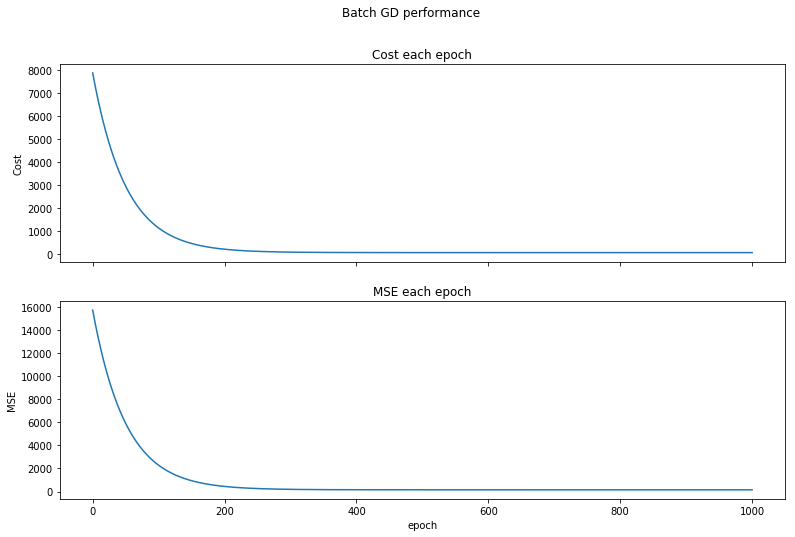

In [20]:
fig, axs = plt.subplots(2, sharex=True, figsize=(13, 8))
fig.suptitle('Batch GD performance')
axs[0].plot(_J)
axs[0].set_title('Cost each epoch')
axs[0].set(ylabel='Cost')
axs[1].plot(_mse)
axs[1].set_title('MSE each epoch')
axs[1].set(ylabel='MSE', xlabel='epoch')
plt.show()

## Stochastic Gradient Descent


Now let's implement SGD from scratch.

In [21]:
def _iter(X, y, 
          batch_size: int=1):
    n_observations = X.shape[0]
    idx = list(range(n_observations))
    random.shuffle(idx)
    for batch_id, i in enumerate(range(0, n_observations, batch_size)):
        _pos = np.array(idx[i: min(i + batch_size, n_observations)])
        yield batch_id, X.take(_pos, axis=0), y.take(_pos)
        

def get_pred(X, theta):
    '''use the weights to predict the yhat'''
    return np.dot(X, theta)


def grad_loss(X, y, theta):
    ''' 
    Compute gradient based using MSE
      https://math.stackexchange.com/questions/1962877/compute-the-gradient-of-mean-square-error
    '''
    y_pred = get_pred(X, theta)
    error = y_pred - y
    loss_gradient = (np.dot(np.transpose(X), error))/(len(X))
    return loss_gradient


In this example, we will use constant learning rate, so no learning rate decaying

In [22]:
def _sgd_regressor(X, y, learning_rate, n_epochs, batch_size=1):
    mse_log = []
    theta_log = []
    total_loss_log = []
    np.random.seed(SEED)
    theta = np.random.rand(len(X[0]))
    for i in range(n_epochs+1):
        total_error = 0
        for batch_id, data, label in _iter(X, y, batch_size):
            grad_loss_= grad_loss(data, label, theta)
            theta = theta - learning_rate * grad_loss_
        
        y_pred = get_pred(X, theta)
        _mse = mean_squared_error(y, y_pred)
        mse_log.append(_mse)
        theta_log.append(theta)
        if i % 100 == 0:
            print(f'Epoch: {i} | MSE: {_mse}')
            
    return theta, theta_log, mse_log



In [23]:
theta, _, mse_ = _sgd_regressor(X_, y, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=1)
y_pred = np.dot(X_, theta)
print(f'Final weights: {theta}')
_ = print_regress_metric(y, y_pred)

Epoch: 0 | MSE: 153.04540115821518
Epoch: 100 | MSE: 154.44085186372178
Epoch: 200 | MSE: 153.85078596098032
Epoch: 300 | MSE: 153.6676955203311
Epoch: 400 | MSE: 150.91499556602082
Epoch: 500 | MSE: 154.67485181260682
Epoch: 600 | MSE: 151.58415753706186
Epoch: 700 | MSE: 156.73817982553746
Epoch: 800 | MSE: 154.27067616596992
Epoch: 900 | MSE: 151.90529089317695
Epoch: 1000 | MSE: 151.96826982841296
Final weights: [100.97503676   0.06986167  45.62307509   0.39058345  53.40644803
  32.89482873]
r2 score = 0.9758655872609822
mae = 9.800269479045237
mse = 151.96826982841296
rmse = 12.32754111039233


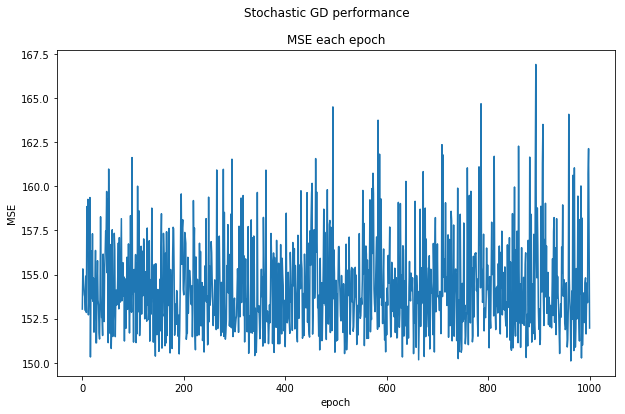

In [24]:
fig, axs = plt.subplots(1, sharex=True, figsize=(10, 6))
fig.suptitle('Stochastic GD performance')
axs.plot(mse_)
axs.set_title('MSE each epoch')
axs.set(ylabel='MSE', xlabel='epoch')
plt.show()

## Mini Batch Gradient Descent

This is similar to SGD but feed batch size ==> `len(X) > batch_size > 1`

In [25]:
theta, _, mse_ = _sgd_regressor(X_, y, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=50)
y_pred = np.dot(X_, theta)
print(f'Final weights: {theta}')
_ = print_regress_metric(y, y_pred)

Epoch: 0 | MSE: 449.53960077546174
Epoch: 100 | MSE: 149.84340702423697
Epoch: 200 | MSE: 149.83389423697255
Epoch: 300 | MSE: 149.86166235922667
Epoch: 400 | MSE: 149.82745194940117
Epoch: 500 | MSE: 149.85772206173098
Epoch: 600 | MSE: 149.84853940142662
Epoch: 700 | MSE: 149.83885577952643
Epoch: 800 | MSE: 149.8347205811635
Epoch: 900 | MSE: 149.8670100298715
Epoch: 1000 | MSE: 149.8573946336627
Final weights: [100.00318323   0.08504223  46.26222115   0.0478891   53.67965285
  33.88967953]
r2 score = 0.976200819959546
mae = 9.728205129299743
mse = 149.8573946336627
rmse = 12.241625489846628


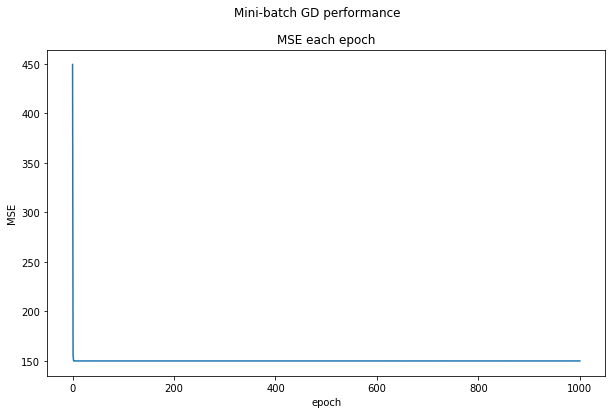

In [26]:
fig, axs = plt.subplots(1, sharex=True, figsize=(10, 6))
fig.suptitle('Mini-batch GD performance')
axs.plot(mse_)
axs.set_title('MSE each epoch')
axs.set(ylabel='MSE', xlabel='epoch')
plt.show()

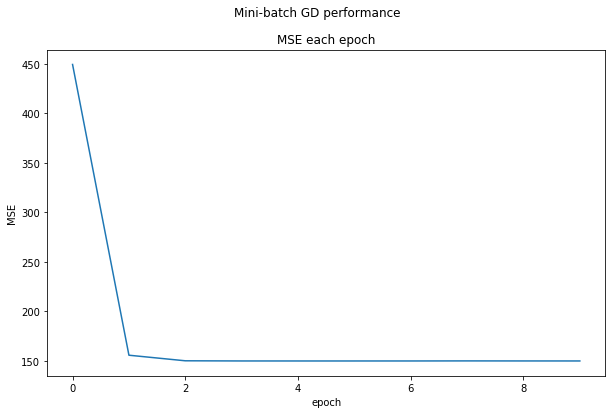

In [27]:
fig, axs = plt.subplots(1, sharex=True, figsize=(10, 6))
fig.suptitle('Mini-batch GD performance')
axs.plot(mse_[0:10])
axs.set_title('MSE each epoch')
axs.set(ylabel='MSE', xlabel='epoch')
plt.show()

## SGD Regressor in sci-kit learn

We can implement SGDRegressor from `sklearn` library to support mini-batch by building custom generator to feed the __chunk__ of training set.

<br>

Below script displays how to implement normal and mini-batch SGD regressor.

In [28]:
SGD_rgs_normal = SGDRegressor(fit_intercept=True, random_state=SEED, eta0=learning_rate,
                              learning_rate='constant', max_iter=n_epochs)
SGD_rgs_normal.fit(X, y)
print(SGD_rgs_normal)
print(f'Intercept: {SGD_rgs_normal.intercept_}, weights: {SGD_rgs_normal.coef_}')
y_pred = SGD_rgs_normal.predict(X)
_ = print_regress_metric(y, y_pred)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=121,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Intercept: [99.324308], weights: [-0.07735028 45.44757928 -0.19159974 52.72339963 35.27975324]
r2 score = 0.9755546791965751
mae = 9.862206859661491
mse = 153.92597897735976
rmse = 12.40669089553535


In [29]:
def _get_chunk(X, y, chunkrows):
    X_chunk, y_chunk = X[chunkrows], y[chunkrows]
    return X_chunk, y_chunk


def _iter_minibatch(X, y, chunk_size):
    '''
    Construct minibatch generator
    '''
    _start = 0
    _total_observation = X.shape[0]
    while _start < _total_observation:
        chunkrows = range(_start, _start + chunk_size)
        X_chunk, y_chunk = _get_chunk(X, y, chunkrows)
        yield X_chunk, y_chunk
        _start += chunk_size
        

mini_batch_generator = _iter_minibatch(X=X, y=y, chunk_size=100)
SGD_model = SGDRegressor(fit_intercept=True, random_state=SEED, eta0=learning_rate,
                         learning_rate='constant', max_iter=n_epochs)
for X_chunk, y_chunk in mini_batch_generator:
    SGD_model.partial_fit(X_chunk, y_chunk)
    
y_pred = SGD_model.predict(X)
print(SGD_model)
print(f'Intercept: {SGD_model.intercept_}, weights: {SGD_model.coef_}')
_ = print_regress_metric(y, y_pred)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=121,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Intercept: [99.43369967], weights: [-1.65969995 46.49161874 -1.21952065 53.25021942 34.54669358]
r2 score = 0.9752638257485646
mae = 9.947475639038714
mse = 155.75740929827745
rmse = 12.480280818085683
